<a href="https://colab.research.google.com/github/leomonteiro92/machine-learning-classes/blob/main/tech_challenge_fase_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importar as bibliotecas necessárias

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics

# 2. Carregar o dataset

Fonte: [Kaggle.com](https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance)

## Colunas
* **Age**: Idade da pessoa segurada
* **Sex**: Sexo biológico (male ou female) da pessoa segurada
* **BMI** (Body mass index): IMC em português, índice de massa corportal, a razão entre peso e altura.
* **Children**: Número de dependentes cobertos (filhos).
* **Smoker**: Indica se o segurado é **fumante** ou não (yes ou no)
* **Região**: Área geográfica da cobertura do plano.
* **Charges**: Custos de `health insurance` (seguro saúde, plano de saúde) por pessoa segurada.



In [63]:
original_dataset = pd.read_csv('sample_data/insurance.csv')
original_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 3. Pré-processamento de dados: Verificar valores nulos

In [64]:
original_dataset.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


# 4. Exploração de dados: Descrição dos dados
Importante para verificar se temos valores anômalos. `age` e `children` são valores discretos. Vemos que o a idade máxima é 64 anos e a mínima 18, e o número de filhos varia entre 0 e 5. Podemos concluir que os dados não são discrepantes.

O BMI (IMC) normal é entre 18,5 e 25, valores acima de 30 podem indicar sobrepeso ou obesidade ([mais detalhes neste link](https://mundoeducacao.uol.com.br/saude-bem-estar/imc.htm)).[link text](https://)


In [65]:
original_dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# 5. Exploração de dados: Distribuição dos valores de charges (valores dos custos)

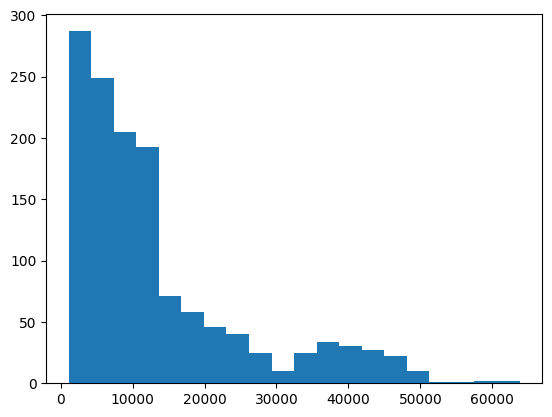

In [66]:
plt.hist(original_dataset['charges'], bins=20)
plt.show()

# 6. Exploração de dados: Verificar charges outliers
A média de `charges` é aproximadamente 13K dinheiros, porém alguns valores estão muito distantes dessa média, sendo outliers, como podemos visualizar no boxplot abaixo.

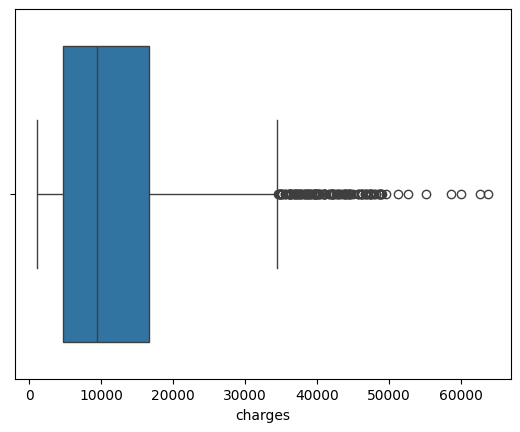

In [67]:
sns.boxplot(x=original_dataset['charges'])
plt.show()

As we can see, there is a lot of outliers (charges above 35000)

---



# 7. Exploração de dados: Gráfico de matriz de correlação entre as *features* númericas (age, BMI, children) vs charges

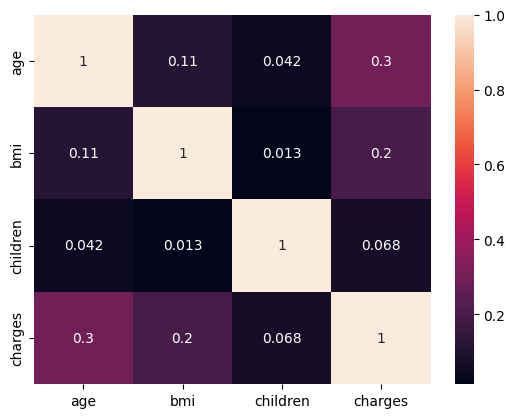

In [68]:
numerical_features = ['age', 'bmi', 'children', 'charges']
correlation_matrix = original_dataset[numerical_features].corr()
correlation_matrix

sns.heatmap(correlation_matrix, annot=True)
plt.show()

# 8. Exploração de dados: Analisar a distribuição de `charges` vs fumantes e não fumantes



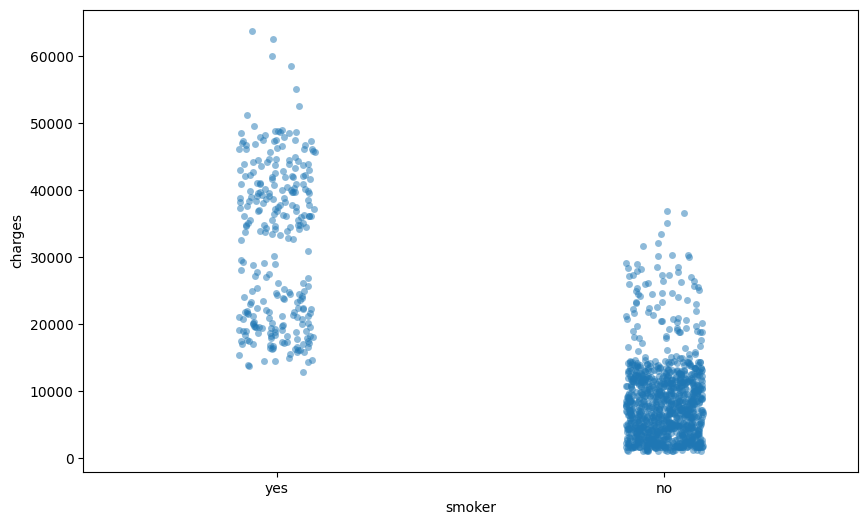

In [69]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="smoker", y="charges", alpha=0.5)
plt.show()

# 9. Exploração de dados: Analisar a distribuição de `charges` vs homens e mulheres

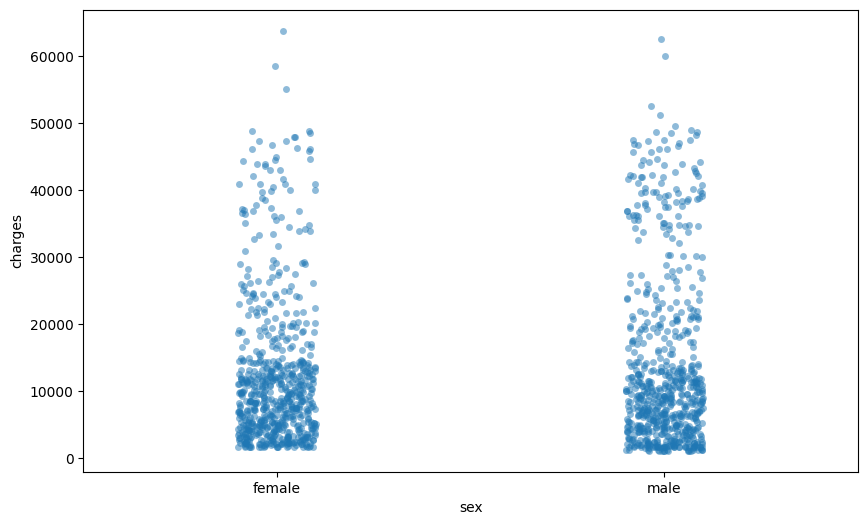

In [70]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="sex", y="charges", alpha=0.5)
plt.show()

# 10. Exploração de dados: Analisar a distribuição de `charges` vs regiões

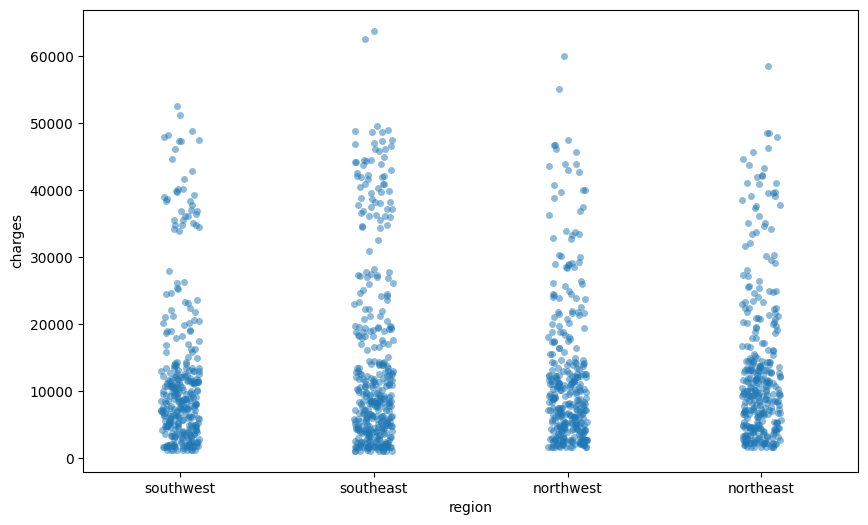

In [71]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=original_dataset, x="region", y="charges", alpha=0.5)
plt.show()

# 11. Exploração de dados: Gráfico de distribuição entre variáveis numéricas (`BMI` e `age`) vs charges


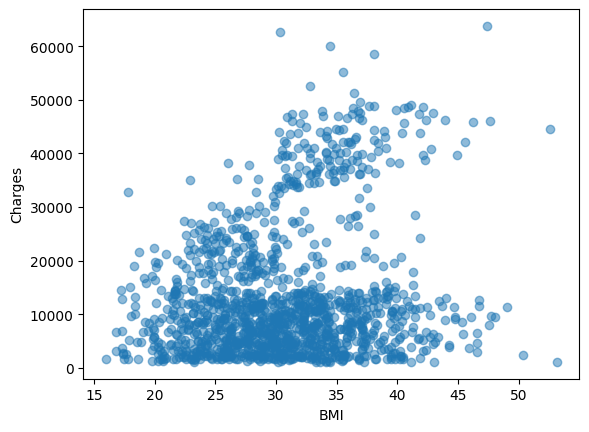

In [72]:
plt.scatter(original_dataset['bmi'], original_dataset['charges'], alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

Os pontos de BMI estão dispostos de tal forma que é difícil imaginar uma reta linear.



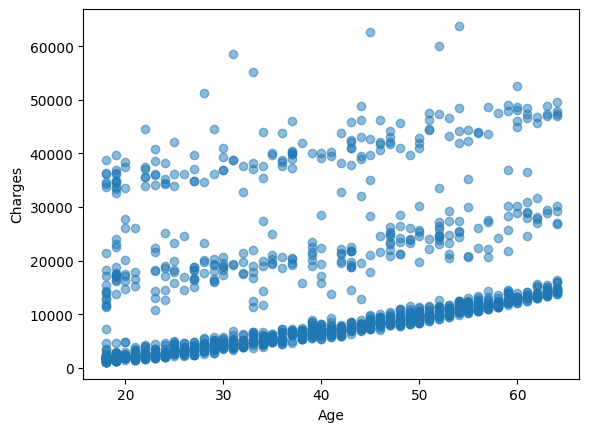

In [73]:
plt.scatter(original_dataset['age'], original_dataset['charges'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

Verificamos uma certa linearidade entre a idade e os custos de plano de saúde.

# 12. Pré-processamento de dados: codificar as variáveis categóricas binárias `sex` e `smoker`

In [74]:
dataset = original_dataset.copy()
# label_encoder = LabelEncoder()
# binary_categorical_features = ['sex', 'smoker']
# for column in binary_categorical_features:
#     dataset[column] = label_encoder.fit_transform(dataset[column])
# dataset.head()

# 13. Pré-processamento de dados: Codificar a variável categórica `region` usando `OneHotEncoder`

`OneHotEncoder` é usado em machine learning para converter dados categóricos em um formato numérico que possa ser utilizado pelos modelos. Muitos algoritmos, como regressão logística, árvores de decisão ou redes neurais, funcionam melhor com dados numéricos de entrada. Aqui está o porquê de usá-lo:

* **Lidar com Dados Categóricos**: Muitos conjuntos de dados contêm características categóricas (como cor, tipo, cidade). Algoritmos de machine learning não podem trabalhar diretamente com esses valores categóricos.

* **Não Pressupõe Relação Ordinal**: Ao contrário do label encoding (codificação de rótulos), onde as categorias são atribuídas a números (por exemplo, vermelho = 1, azul = 2, verde = 3), o OneHotEncoder evita sugerir uma relação ordinal. Por exemplo, "azul" não é maior que "vermelho". Ele cria uma coluna binária para cada categoria.

* **Representação Binária**: O OneHotEncoder representa cada categoria como um vetor binário. Por exemplo:
Se houver três categorias: vermelho, azul, verde
A representação codificada em one-hot seria:
  * vermelho → [1, 0, 0]
  * azul → [0, 1, 0]
  * verde → [0, 0, 1]

* Evitar Viés: Ao converter categorias em formato binário, o OneHotEncoder impede que o modelo assuma que certas categorias são mais importantes ou que têm uma relação hierárquica.

In [75]:
onehot_encoder = OneHotEncoder()
onehot_categorical_features = ['region', 'sex', 'smoker']

# encode column region in the format region_sourthwest, region_southeast, region_northwest, region_northeast
onehot_encoded = onehot_encoder.fit_transform(dataset[onehot_categorical_features]).toarray()
onehot_encoded = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_categorical_features))
dataset = pd.concat([dataset, onehot_encoded], axis=1)
dataset = dataset.drop(columns=onehot_categorical_features)
dataset.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


# 14: Exploração de dados: Matriz de correlação incluindo as variáveis categóricas

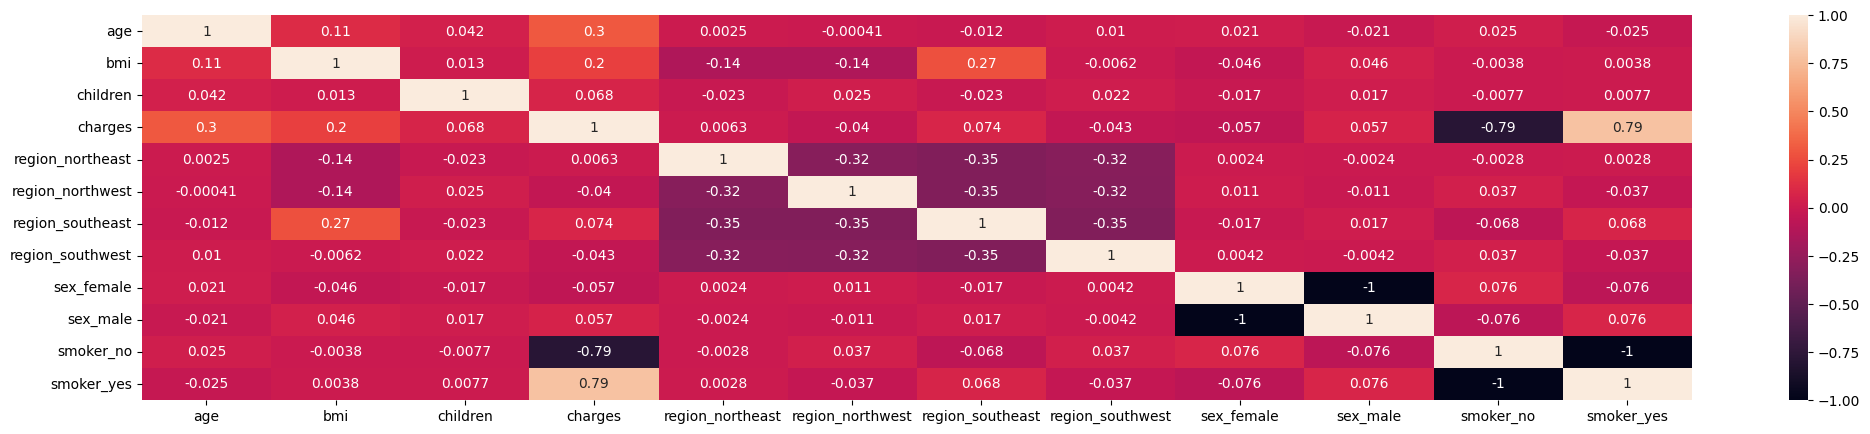

In [76]:
plt.figure(figsize=(25, 5))
correlation_matrix = dataset.corr()
correlation_matrix

sns.heatmap(correlation_matrix, annot=True)
plt.show()

# 15. Pré-processamento de dados: Normalização da escala das colunas

In [77]:
# independent_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
# independent_features = ['age', 'sex', 'bmi', 'children', 'smoker'] + list(onehot_encoder.get_feature_names_out(onehot_categorical_features))
independent_features = ['age', 'bmi', 'children'] + list(onehot_encoder.get_feature_names_out(onehot_categorical_features))
X = dataset[independent_features]
dependent_features = [
    'charges',
]
y = dataset[dependent_features]

scaler = StandardScaler()
X = scaler.fit_transform(X)


# 16. Pré-processamento de dados: Criação de ranges de `charges`
Queremos que nas nossas bases de teste e treino tenham tanto `charges` "mais baratos" e "mais caros"

In [78]:
dataset['charge_group'] = pd.qcut(dataset['charges'], q=7, labels=False)

# 17. Modelagem: Divisão das bases de treino e teste

In [79]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=dataset["charge_group"], test_size=0.2, random_state=42)

# 18. Modelagem: Método 1 - Regressão Linear

In [80]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

lin_reg_predictions = lin_reg_model.predict(X_test)

print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, lin_reg_predictions))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, lin_reg_predictions))

Mean squared error: 30857887.34
Coefficient of determination: 0.80


In [81]:
X_test_original = scaler.inverse_transform(X_test)
X_columns = dataset[independent_features].columns
X_test_original = pd.DataFrame(X_test_original, columns=X_columns)

# for column in binary_categorical_features:
#     X_test_original[column] = label_encoder.inverse_transform(X_test_original[column].astype(int))

onehot_encoded_cols = onehot_encoder.get_feature_names_out(onehot_categorical_features)
X_test_original[onehot_categorical_features] = onehot_encoder.inverse_transform(X_test_original[onehot_encoded_cols].values)
X_test_original.drop(columns=onehot_encoded_cols, inplace=True)

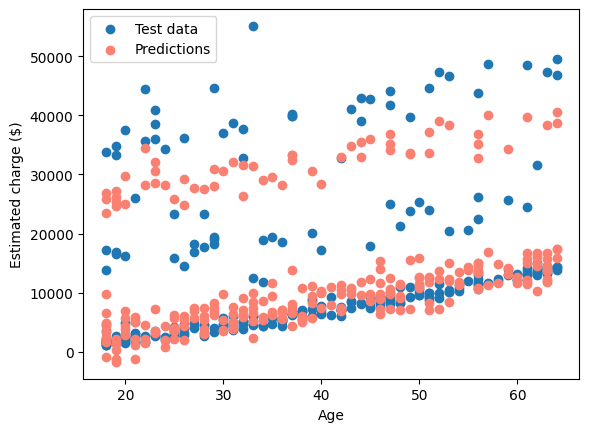

In [82]:
plt.scatter(X_test_original["age"], y_test, label="Test data")
plt.scatter(X_test_original["age"], lin_reg_predictions, color="salmon", label="Predictions")
plt.xlabel("Age")
plt.ylabel("Estimated charge ($)")
plt.legend()
plt.show()


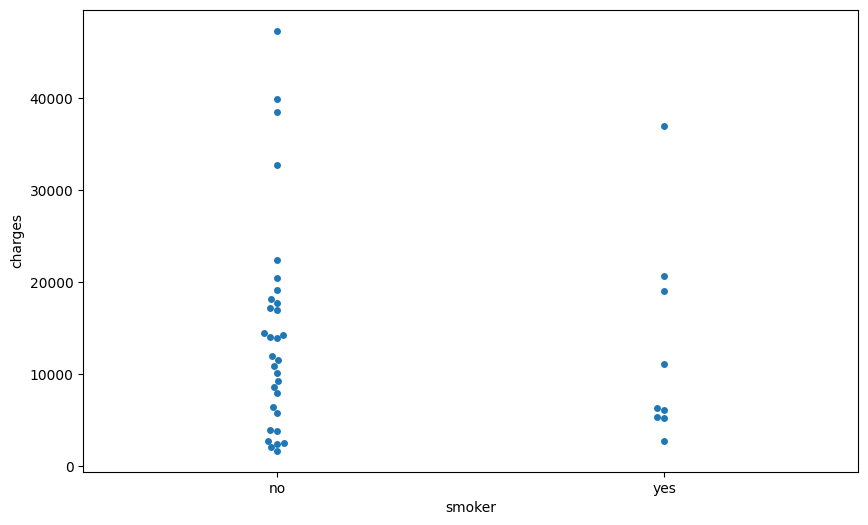

In [83]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x=X_test_original["smoker"], y=y_test["charges"])
plt.show()

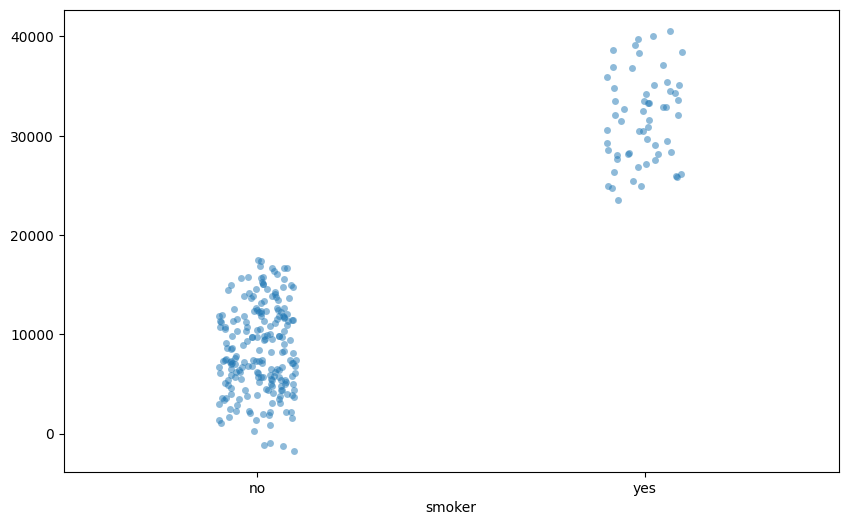

In [84]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=X_test_original["smoker"], y=lin_reg_predictions[:, 0], alpha=0.5)
plt.show()

# 19. Modelagem: Método 2 - Random Forests

In [85]:
# gs_params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 3, 4]
# }

# rf_model = GridSearchCV(RandomForestRegressor(), gs_params, cv=5)

rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())
# rf_model.best_params_
rf_predictions = rf_model.predict(X_test)

print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, rf_predictions))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, rf_predictions))

Mean squared error: 15166413.54
Coefficient of determination: 0.90


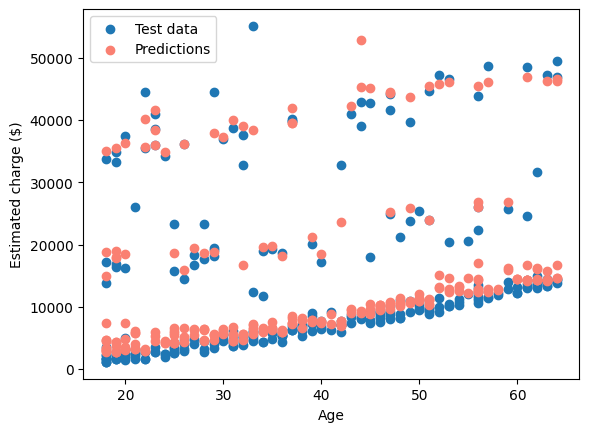

In [86]:
# X_columns = dataset[independent_features].columns
# X_test_original = pd.DataFrame(X_test, columns=X_columns)

plt.scatter(X_test_original["age"], y_test, label="Test data")
plt.scatter(X_test_original["age"], rf_predictions, color="salmon", label="Predictions")
plt.xlabel("Age")
plt.ylabel("Estimated charge ($)")
plt.legend()
plt.show()

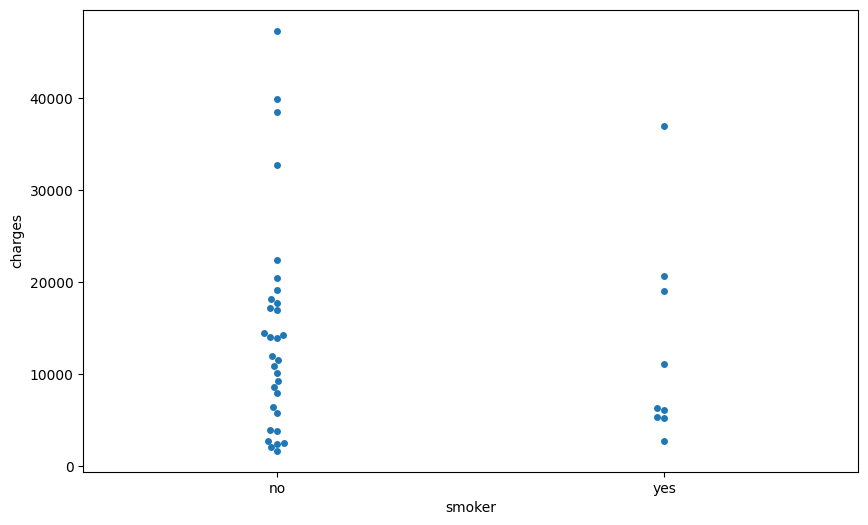

In [87]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x=X_test_original["smoker"], y=y_test["charges"])
plt.show()

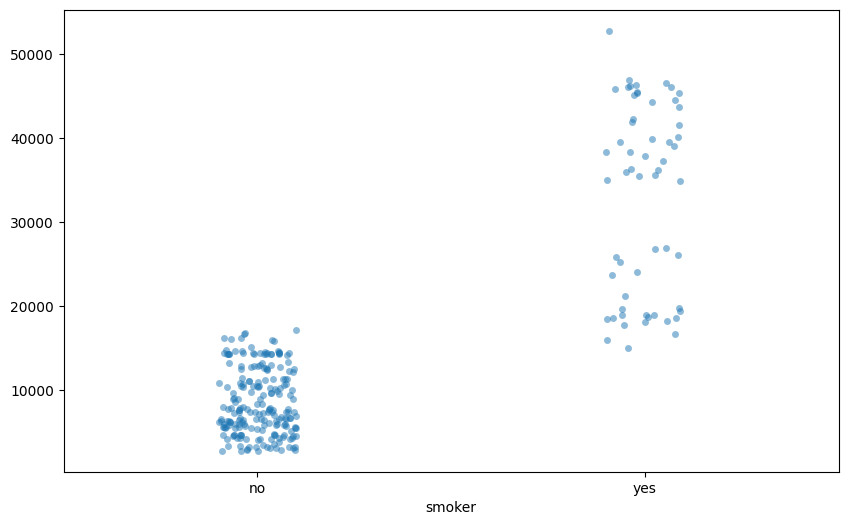

In [88]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=X_test_original["smoker"], y=rf_predictions, alpha=0.5)
plt.show()

# 20. Modelagem: Método 3 - Gradient Boosting Regressor

In [89]:
# # gs_params = {
# #     'n_estimators': [50, 100, 200],
# #     'max_depth': [3, 5, 7],
# #     'min_samples_split': [2, 3, 4],
# #     'learning_rate': [0.01, 0.1, 1],
# # }

# gb_model = GridSearchCV(GradientBoostingRegressor(), gs_params, cv=5)
# gb_model.fit(X_train, y_train.values.ravel())
# gb_model.best_params_

gb_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, min_samples_split=2, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train.values.ravel())
gb_predictions = gb_model.predict(X_test)

print('Root mean squared error: %.2f' % metrics.root_mean_squared_error(y_test, gb_predictions))
print('R^2: %.2f' % metrics.r2_score(y_test, gb_predictions))

Root mean squared error: 3763.42
R^2: 0.91


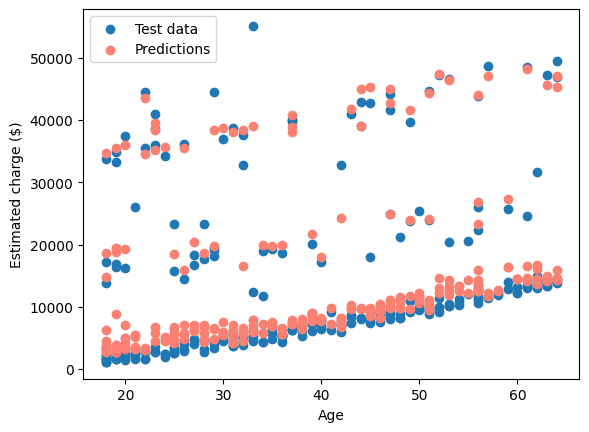

In [90]:
plt.scatter(X_test_original["age"], y_test, label="Test data")
plt.scatter(X_test_original["age"], gb_predictions, color="salmon", label="Predictions")
plt.xlabel("Age")
plt.ylabel("Estimated charge ($)")
plt.legend()
plt.show()

# TODOs
* Testar reduzir a dimensionalidade dos dados (usando PCA)